
# Pandas Built‑in Data Visualization — Step‑by‑Step Lab (Beginner → Intermediate)

**Goal:** Learn how to make quick, effective charts directly from Pandas DataFrames/Series using `.plot()` (Matplotlib under the hood).  
**Who is this for?** Students at **entry** and **mid** levels who want a gentle, practical path with lots of examples.

### What you'll learn
- The Pandas `.plot()` API and common plot types
- How to prepare/reshape data for plotting (wide vs long format)
- Styling, annotations, subplots, and saving figures
- Time series basics (resample, rolling stats) and handling missing values
- When to use which chart (and when **not** to)

> 💡 **Tip:** Pandas plotting is great for quick EDA; for publication‑ready visuals, you might later explore Matplotlib or Seaborn directly. In this lab we stick to **Pandas + Matplotlib** only.



## 0) Setup

Run the cell below to import the libraries we need. No internet or external datasets required.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make output a bit bigger by default
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

np.random.seed(42)  # for reproducibility
print(pd.__version__)


2.3.1



## 1) Create a few toy datasets

We'll generate small, realistic datasets we can reuse across charts:

- **Time series**: daily sales & temperature  
- **Categorical**: monthly sales by product category  
- **Scatter data**: advertising spend vs. sales  
- **Exam scores**: distributions for 2 classes


In [40]:

# --- Time series dataset ---
dates = pd.date_range('2024-01-01', periods=180, freq='D')
temp = 25 + 5*np.sin(np.linspace(0, 3*np.pi, len(dates))) + np.random.normal(0, 1.0, len(dates))  # °C
sales = 200 + 10*np.arange(len(dates)) / len(dates) * 50  # slow upward trend
sales += 20*np.sin(np.linspace(0, 5*np.pi, len(dates)))   # seasonality
sales += np.random.normal(0, 10, len(dates))               # noise
df_ts = pd.DataFrame({'date': dates, 'temperature_C': temp, 'daily_sales': sales}).set_index('date')

# Introduce some missing data
df_ts.loc['2024-02-15':'2024-02-18', 'temperature_C'] = np.nan

# --- Categorical dataset ---
months = pd.period_range('2024-01', periods=6, freq='M').astype(str)
categories = ['A', 'B', 'C']
rows = []
for m in months:
    for c in categories:
        rows.append({'month': m, 'category': c, 'sales': np.random.randint(150, 400)})
df_cat = pd.DataFrame(rows)

# --- Scatter dataset: advertising spend vs sales ---
n = 150
df_scatter = pd.DataFrame({
    'tv_spend_k': np.random.uniform(0, 100, n),
    'social_spend_k': np.random.uniform(0, 60, n),
})
# true relationship + noise
df_scatter['sales_k'] = 5 + 0.3*df_scatter['tv_spend_k'] + 0.45*df_scatter['social_spend_k'] + np.random.normal(0, 3, n)

# --- Exam scores ---
df_scores = pd.DataFrame({
    'Class': np.repeat(['Class 1', 'Class 2'], 120),
    'Score': np.concatenate([np.random.normal(70, 10, 120), np.random.normal(75, 12, 120)]).clip(0, 100)
})




 **Time series**: daily sales & temperature  

In [35]:
df_ts

,temperature_C,daily_sales
date,,
2024-01-01,25.496714,206.256673
2024-01-02,25.124876,195.959030
2024-01-03,26.173240,198.338797
2024-01-04,27.309536,218.362687
2024-01-05,25.811127,215.753523
...,...,...
2024-06-24,26.872463,682.962857
2024-06-25,25.799508,693.908387
2024-06-26,26.979085,692.272247


**Categorical**: monthly sales by product category  

In [37]:
df_cat

,month,category,sales
0,2024-01,A,150
1,2024-01,B,280
2,2024-01,C,354
3,2024-02,A,241
4,2024-02,B,339
5,2024-02,C,398
6,2024-03,A,340
7,2024-03,B,262
8,2024-03,C,302
9,2024-04,A,205


**Scatter data**: advertising spend vs. sales  

In [38]:
df_scatter

,tv_spend_k,social_spend_k,sales_k
0,55.600504,32.195439,42.939693
1,32.268639,55.442506,36.828805
2,4.340078,14.166992,22.200496
3,92.464333,45.597325,53.804818
4,91.911572,31.875945,39.198853
...,...,...,...
145,0.259502,29.638889,16.476723
146,86.830111,45.278118,54.158315
147,8.451701,6.174962,7.564606
148,59.727808,32.188881,39.538207



## 2) Quick tour of `.plot()`

Most Pandas objects have `.plot(kind=...)` with many kinds available:

- `line` (default), `bar`, `barh`, `area`, `box`, `hist`, `kde`, `density`, `pie`, `scatter`, `hexbin`
- Useful args: `title`, `xlabel`, `ylabel`, `legend`, `xlim`, `ylim`, `grid`, `alpha`, `rot`, `figsize`, `subplots`  
- DataFrame‑specific: `x=`, `y=`, `kind=`, `by=`, `secondary_y=True`, `stacked=True`

> ❗ **Rule of thumb**: Pick the chart type that best matches your question.



## 3) Line plots (time series)

Great for trends over time.


In [45]:
df_ts

,temperature_C,daily_sales
date,,
2024-01-01,26.183414,183.693266
2024-01-02,24.602433,206.240315
2024-01-03,26.548693,184.883204
2024-01-04,25.878091,208.206924
2024-01-05,24.659908,234.231971
...,...,...
2024-06-24,26.357360,678.185310
2024-06-25,27.055683,700.552697
2024-06-26,26.223288,708.901928


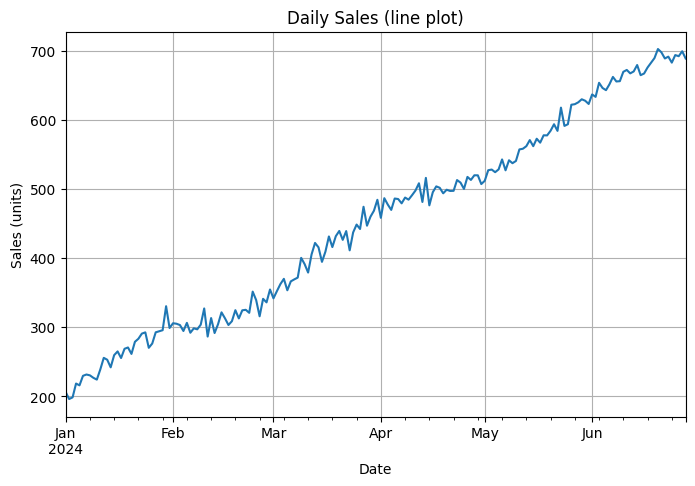

In [3]:

# a) Single series
ax = df_ts['daily_sales'].plot(title='Daily Sales (line plot)')
ax.set_xlabel('Date'); ax.set_ylabel('Sales (units)')
plt.show()


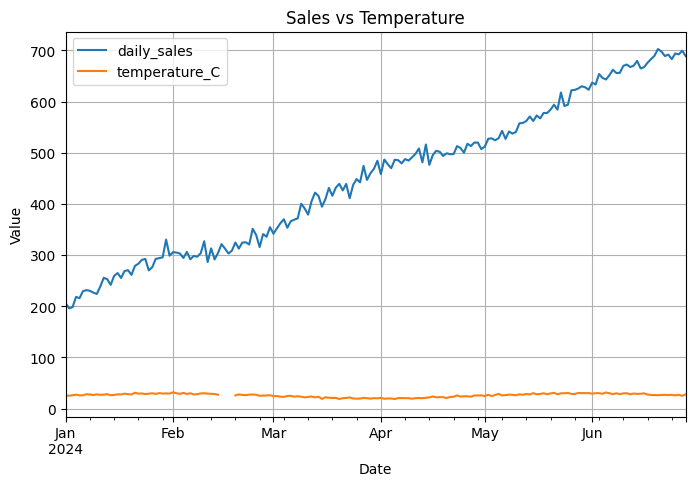

In [4]:

# b) Multiple series & legend
ax = df_ts[['daily_sales', 'temperature_C']].plot(title='Sales vs Temperature')
ax.set_xlabel('Date'); ax.set_ylabel('Value')
plt.show()


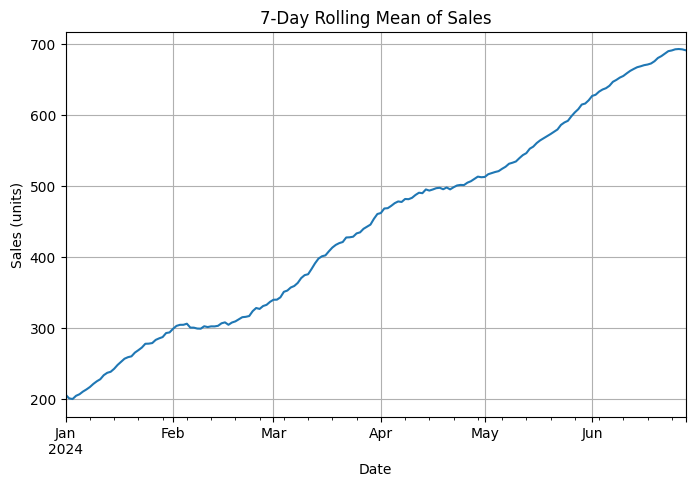

In [5]:

# c) Rolling average to smooth noise
ax = df_ts['daily_sales'].rolling(window=7, min_periods=1).mean().plot(title='7‑Day Rolling Mean of Sales')
ax.set_xlabel('Date'); ax.set_ylabel('Sales (units)')
plt.show()



## 4) Bar charts (categorical comparisons)

Use bars to compare **categories** or **groups**.


In [44]:
df_cat

,month,category,sales
0,2024-01,A,286
1,2024-01,B,248
2,2024-01,C,298
3,2024-02,A,222
4,2024-02,B,305
5,2024-02,C,339
6,2024-03,A,387
7,2024-03,B,264
8,2024-03,C,156
9,2024-04,A,229


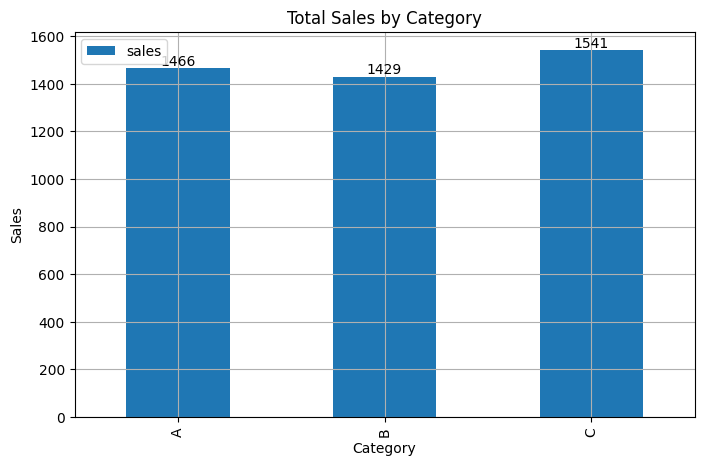

In [46]:

# a) Total sales by category (grouped + bar)
cat_totals = df_cat.groupby('category', as_index=False)['sales'].sum()


ax = cat_totals.plot(kind='bar', x='category', y='sales', title='Total Sales by Category')
ax.set_xlabel('Category'); ax.set_ylabel('Sales')
# Add value labels if supported by Matplotlib
if hasattr(ax, 'bar_label'):
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f')
plt.show()


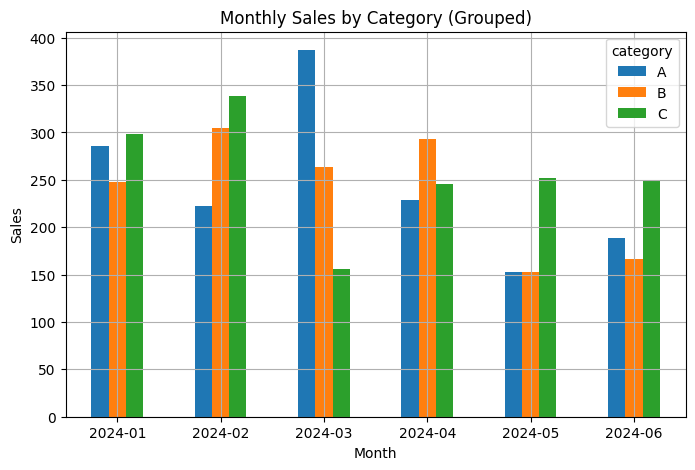

In [47]:

# b) Grouped bars: month vs category (pivot to wide)
wide = df_cat.pivot(index='month', columns='category', values='sales')


ax = wide.plot(kind='bar', title='Monthly Sales by Category (Grouped)')
ax.set_xlabel('Month'); ax.set_ylabel('Sales'); plt.xticks(rotation=0)
plt.show()


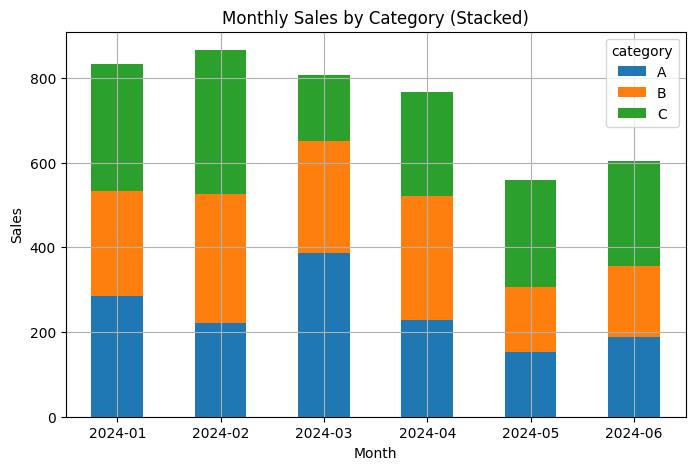

In [48]:

# c) Stacked bars
ax = wide.plot(kind='bar', stacked=True, title='Monthly Sales by Category (Stacked)')


ax.set_xlabel('Month'); ax.set_ylabel('Sales'); plt.xticks(rotation=0)
plt.show()


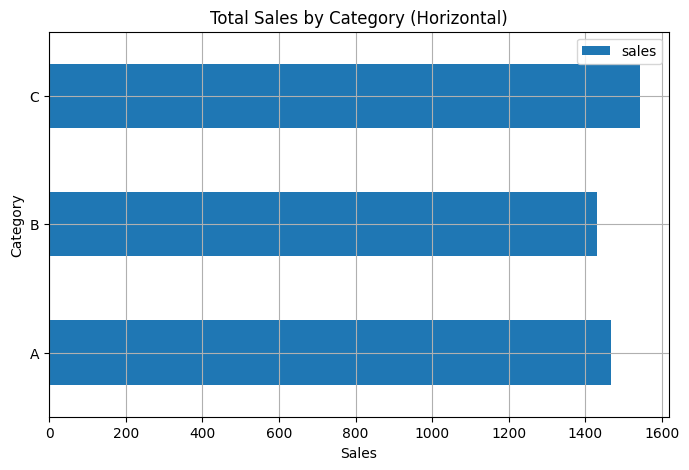

In [49]:

# d) Horizontal bars (useful for long labels)
ax = cat_totals.set_index('category').plot(kind='barh', title='Total Sales by Category (Horizontal)')


ax.set_xlabel('Sales'); ax.set_ylabel('Category')
plt.show()



## 5) Distributions: Histograms & KDE

Use **histograms** to see frequency/counts in bins.  
Use **KDE (kernel density estimate)** to see a smooth estimate of the distribution.


In [51]:
df_scores

,Class,Score
0,Class 1,67.781391
1,Class 1,74.216845
2,Class 1,65.647778
3,Class 1,77.505869
4,Class 1,71.959750
...,...,...
235,Class 2,72.103027
236,Class 2,86.423524
237,Class 2,88.213869
238,Class 2,70.080474


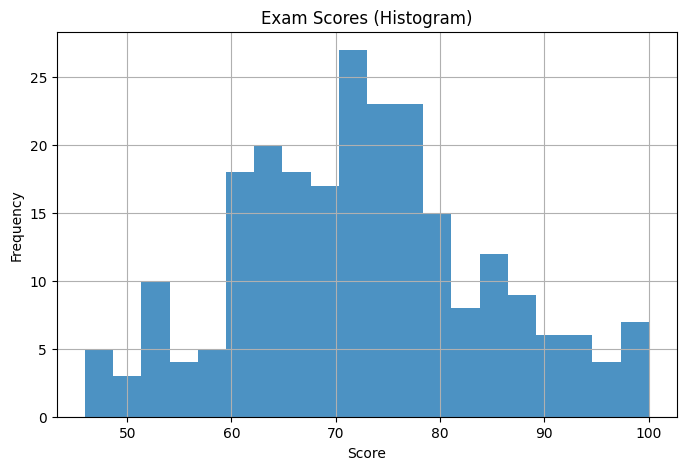

In [50]:

# a) Histogram: exam scores overall
ax = df_scores['Score'].plot(kind='hist', bins=20, title='Exam Scores (Histogram)', alpha=0.8)

ax.set_xlabel('Score')
plt.show()


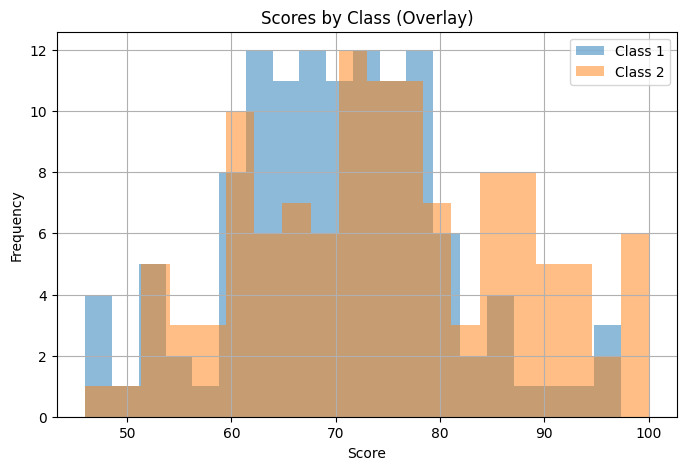

In [52]:

# b) Histogram by class (overlay)
ax = None

for cls, data in df_scores.groupby('Class'):
    ax = data['Score'].plot(kind='hist', bins=20, alpha=0.5, title='Scores by Class (Overlay)', ax=ax, legend=True, label=cls)
ax.set_xlabel('Score')
plt.show()


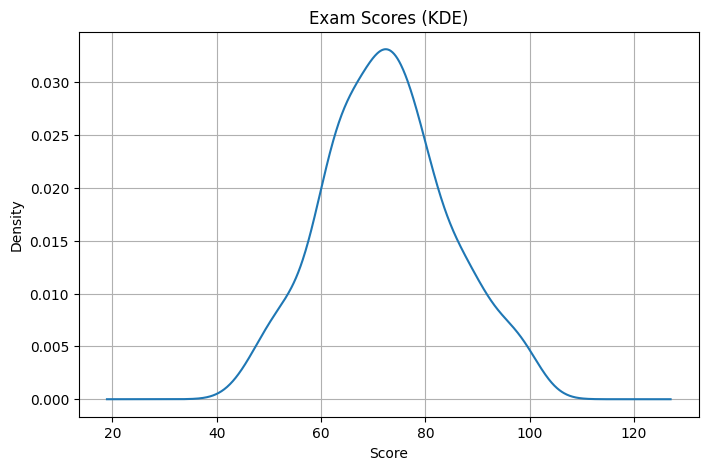

In [53]:

# c) KDE (smooth density)
ax = df_scores['Score'].plot(kind='kde', title='Exam Scores (KDE)')

ax.set_xlabel('Score')
plt.show()



## 6) Box plots (spread, outliers)

Box plots show median, quartiles, and potential outliers.


In [43]:
df_scores

,Class,Score
0,Class 1,67.781391
1,Class 1,74.216845
2,Class 1,65.647778
3,Class 1,77.505869
4,Class 1,71.959750
...,...,...
235,Class 2,72.103027
236,Class 2,86.423524
237,Class 2,88.213869
238,Class 2,70.080474


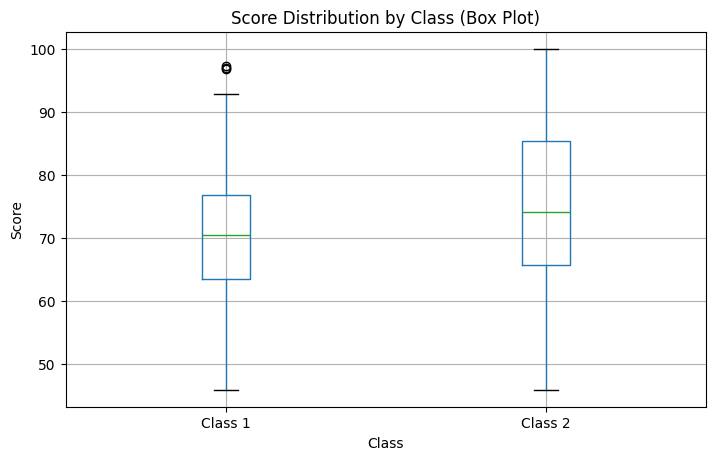

In [54]:

ax = df_scores.boxplot(by='Class', column='Score', grid=True)

plt.suptitle('')  # remove automatic suptitle
plt.title('Score Distribution by Class (Box Plot)')
plt.xlabel('Class'); plt.ylabel('Score')
plt.show()



## 7) Area & Pie charts

- **Area**: cumulative magnitude over time or ordered categories.  
- **Pie**: use sparingly; hard to compare slices precisely.


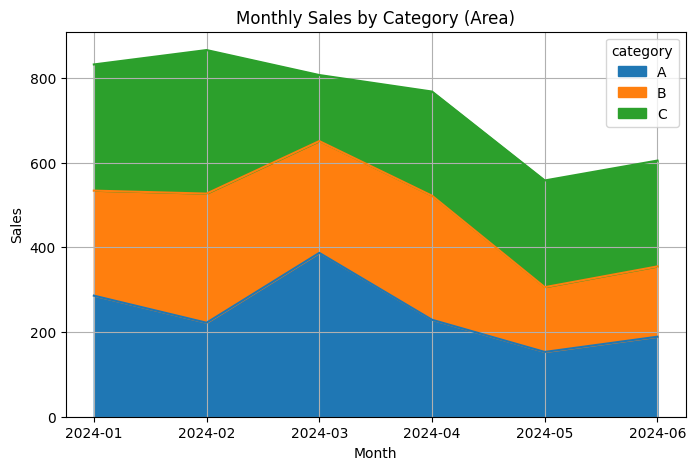

In [55]:

# a) Area chart from wide monthly data
ax = wide.plot(kind='area', stacked=True, title='Monthly Sales by Category (Area)')


ax.set_xlabel('Month'); ax.set_ylabel('Sales'); plt.xticks(rotation=0)
plt.show()


Last month in data: 2024-06


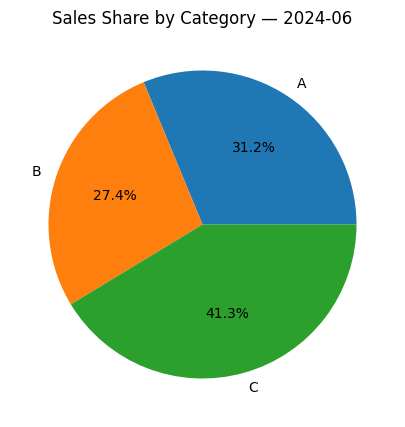

In [59]:

# b) Pie chart for a single period (e.g., last month in our data)
last_month = wide.index[-1]
print(f"Last month in data: {last_month}")

ax = wide.loc[last_month].plot(kind='pie', autopct='%1.1f%%', ylabel='', title=f'Sales Share by Category — {last_month}')
plt.show()



## 8) Scatter & Hexbin (relationships)

Use **scatter** for relationships between two numeric variables.  
Use **hexbin** when you have many points and want density.


In [61]:
df_scatter

,tv_spend_k,social_spend_k,sales_k
0,61.521944,33.901320,35.380978
1,30.625362,41.333118,34.488678
2,62.389584,52.399375,43.297122
3,52.704146,38.177481,45.235483
4,42.608338,45.667292,38.572763
...,...,...,...
145,73.280154,25.127599,41.593259
146,54.223721,15.609467,29.050187
147,59.034769,43.849258,42.252259
148,50.836055,58.877825,46.183235


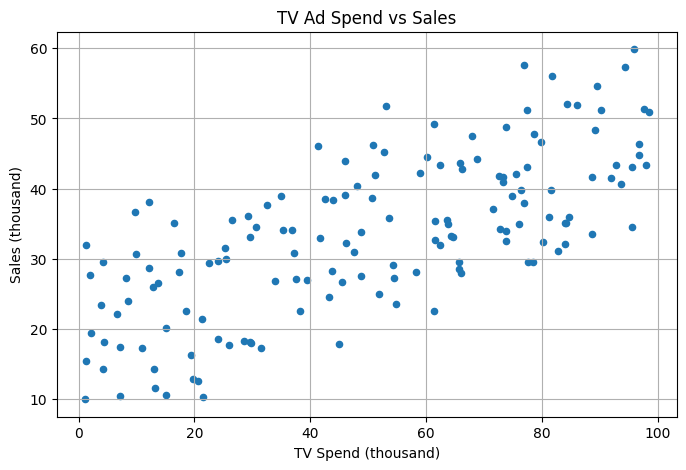

In [60]:

# a) Scatter: TV spend vs Sales
ax = df_scatter.plot(kind='scatter', x='tv_spend_k', y='sales_k', title='TV Ad Spend vs Sales')

ax.set_xlabel('TV Spend (thousand)'); ax.set_ylabel('Sales (thousand)')
plt.show()


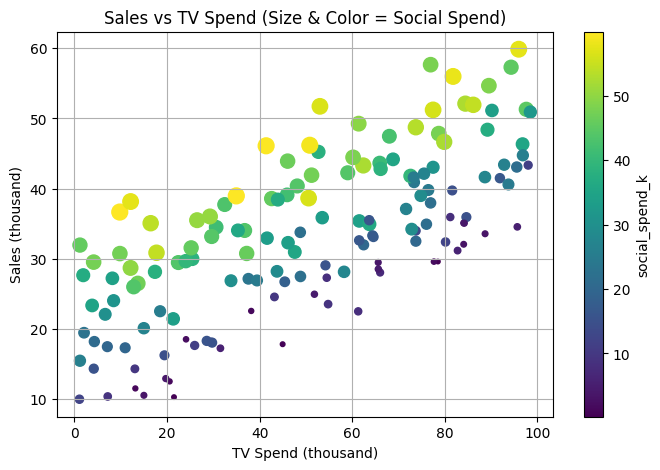

In [62]:

# b) Scatter: encode a 3rd variable with size/color
ax = df_scatter.plot(kind='scatter', x='tv_spend_k', y='sales_k',
                     s=10 + 2*df_scatter['social_spend_k'],  # size ~ social spend
                     c='social_spend_k', cmap='viridis',  # color ~ social spend
                     title='Sales vs TV Spend (Size & Color = Social Spend)')

ax.set_xlabel('TV Spend (thousand)'); ax.set_ylabel('Sales (thousand)')
plt.show()


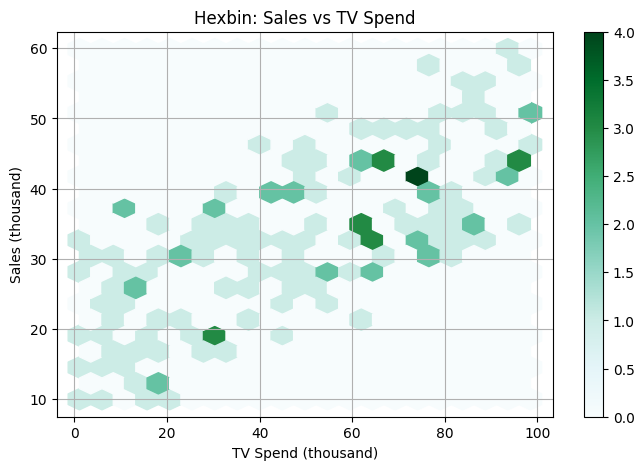

In [63]:

# c) Hexbin (good for large datasets)
ax = df_scatter.plot(kind='hexbin', x='tv_spend_k', y='sales_k', gridsize=20, title='Hexbin: Sales vs TV Spend')

ax.set_xlabel('TV Spend (thousand)'); ax.set_ylabel('Sales (thousand)')
plt.show()



## 9) Time series extras: resample, secondary axis, missing data

Common techniques for temporal data.


In [65]:
df_ts

,temperature_C,daily_sales
date,,
2024-01-01,26.183414,183.693266
2024-01-02,24.602433,206.240315
2024-01-03,26.548693,184.883204
2024-01-04,25.878091,208.206924
2024-01-05,24.659908,234.231971
...,...,...
2024-06-24,26.357360,678.185310
2024-06-25,27.055683,700.552697
2024-06-26,26.223288,708.901928


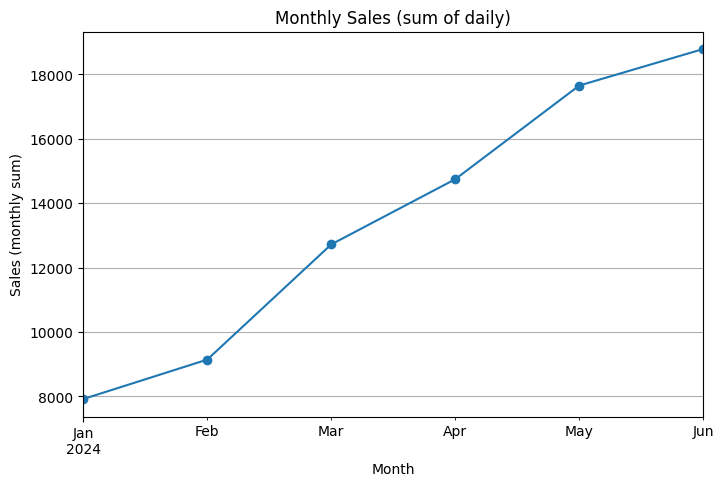

In [64]:

# a) Resample daily -> monthly sum
monthly_sales = df_ts['daily_sales'].resample('MS').sum()

ax = monthly_sales.plot(marker='o', title='Monthly Sales (sum of daily)')
ax.set_xlabel('Month'); ax.set_ylabel('Sales (monthly sum)')
plt.show()


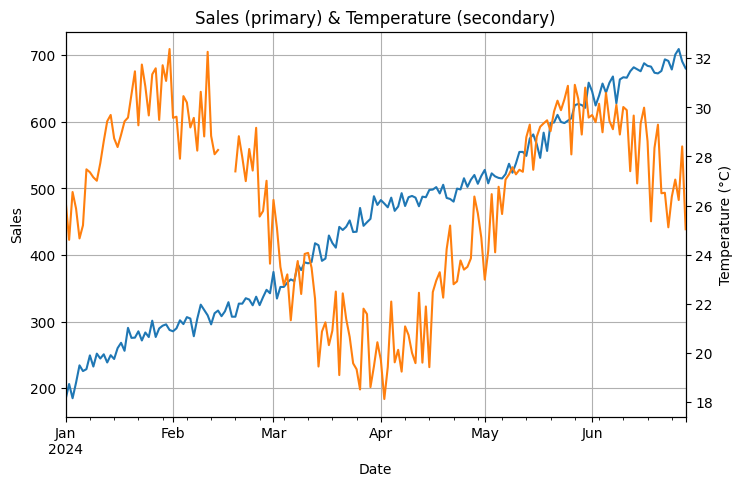

In [66]:

# b) Dual/secondary axis example (sales vs temperature)
ax = df_ts['daily_sales'].plot(title='Sales (primary) & Temperature (secondary)')

df_ts['temperature_C'].plot(ax=ax, secondary_y=True)
ax.set_xlabel('Date'); ax.set_ylabel('Sales')
ax.right_ax.set_ylabel('Temperature (°C)')
plt.show()


Missing before: 4
Missing after interpolate: 0


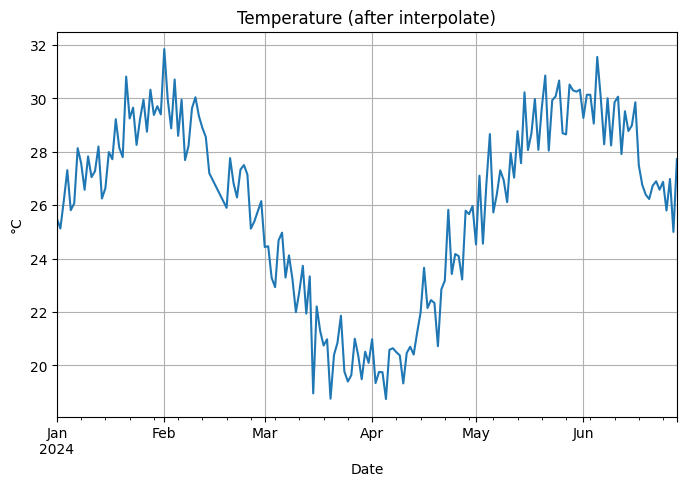

In [21]:

# c) Handle missing values
print("Missing before:", df_ts['temperature_C'].isna().sum())
filled = df_ts['temperature_C'].interpolate()
print("Missing after interpolate:", filled.isna().sum())

ax = filled.plot(title='Temperature (after interpolate)')
ax.set_xlabel('Date'); ax.set_ylabel('°C')
plt.show()



## 10) Styling & annotations

Titles, labels, limits, and annotations help your story land.


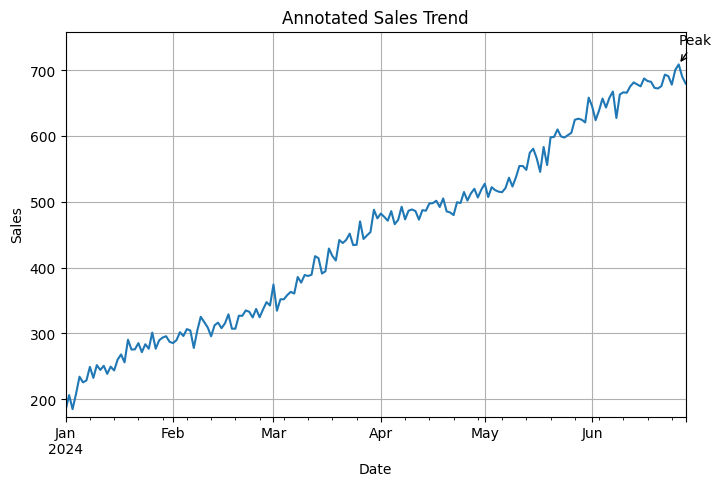

In [67]:

ax = df_ts['daily_sales'].plot(title='Annotated Sales Trend')
ax.set_xlabel('Date'); ax.set_ylabel('Sales')

# Annotate a local maximum
peak_date = df_ts['daily_sales'].idxmax()
peak_val = df_ts['daily_sales'].max()
ax.annotate('Peak', xy=(peak_date, peak_val),
            xytext=(peak_date, peak_val + 30),
            arrowprops=dict(arrowstyle='->'))

ax.set_ylim(df_ts['daily_sales'].min() - 10, df_ts['daily_sales'].max() + 50)
plt.show()



## 11) Subplots & layout

Quickly compare multiple columns.


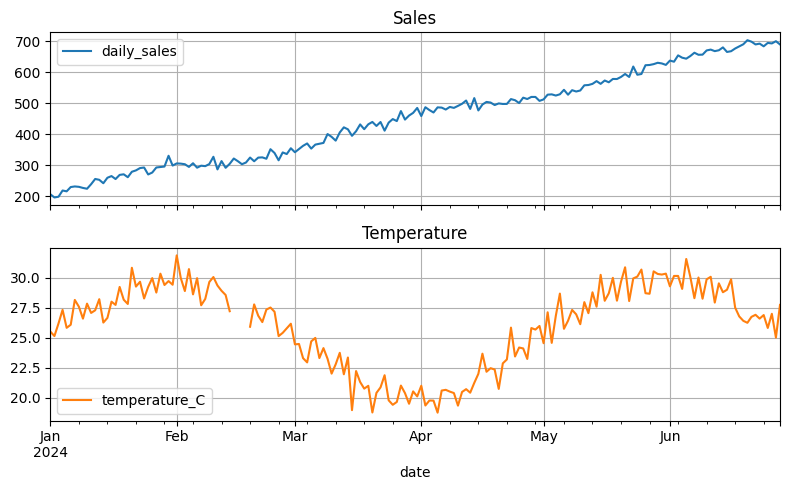

In [ ]:

ax_array = df_ts[['daily_sales','temperature_C']].plot(subplots=True, layout=(2,1), sharex=True, title=['Sales','Temperature'])

plt.tight_layout()
plt.show()
